# CTA MST Image Cleaning using a Segmentation Autoencoder

In [31]:
# Importing some libraries

# Torch 
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# Other libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score


**Unpacking the data**

In this first part, some functions are defined to unpack the data.

In [15]:
class CPU_Unpickler(pickle.Unpickler):
    # to avoid errors that occur when loading pickle files on cpu that were originally saved using a gpu
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [16]:
# Function that enables you to unpack a certain chunk of data
def load_chunk_file(file_path, chunk_i):
    with open(file_path+f'chunk_{chunk_i}', 'rb') as file:
            loaded_data = CPU_Unpickler(file).load()
            
    return loaded_data

In [17]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    mask_gamma_ray = np.array((data_noisy_all[1]==1))
    data_noisy_chunk = np.array(data_noisy_all[0])[mask_gamma_ray]
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])[mask_gamma_ray]
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
# Get it in the right shape
data_noisy = data_noisy_tot.reshape(64*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(64*chunk_tot, 56, 56)


In [18]:
N_examples = len(data_noisy)
print(f"Number of images: {N_examples}")

Number of images: 6400


**Exploratory Data Analysis**

In this section, we have a look at some of the noisy and true data.

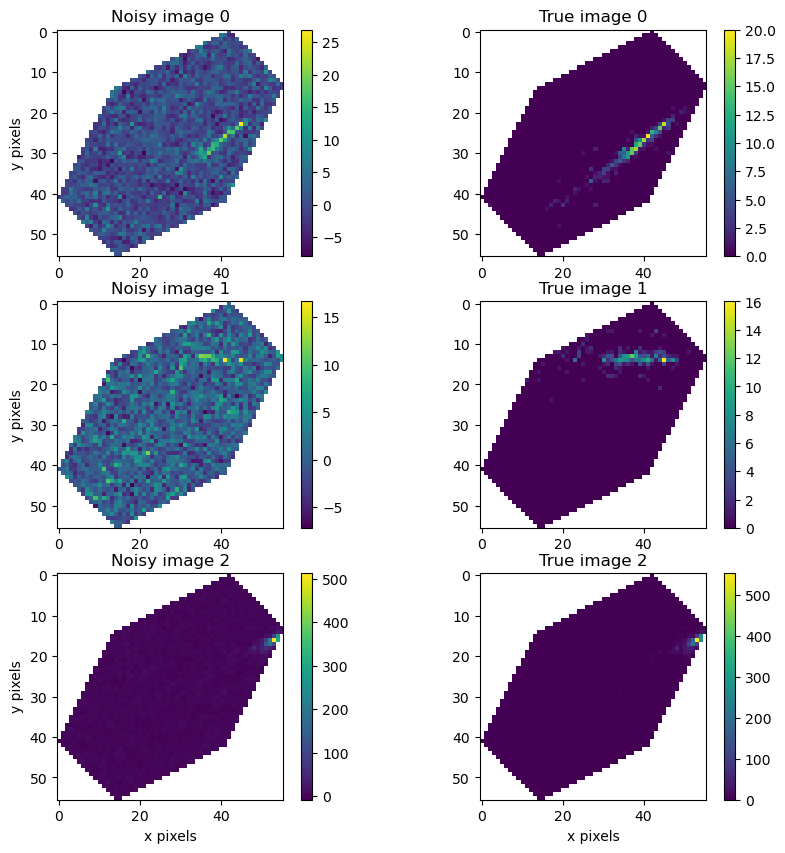

In [19]:
n_images = 3 # Compare 3 examples

fig, axs = plt.subplots(n_images, 2, figsize=(10,10))

for i in range(0,n_images):
    im_noisy = axs[i,0].imshow(data_noisy[i])
    axs[i,0].set_title(f"Noisy image {i}")
    axs[i,0].set_ylabel("y pixels")
    plt.colorbar(im_noisy, ax=axs[i,0])
    
    im_true = axs[i,1].imshow(data_true[i])
    axs[i,1].set_title(f"True image {i}")
    plt.colorbar(im_true, ax=axs[i,1])
    
    
axs[i,0].set_xlabel("x pixels")
axs[i,1].set_xlabel("x pixels")



plt.show()

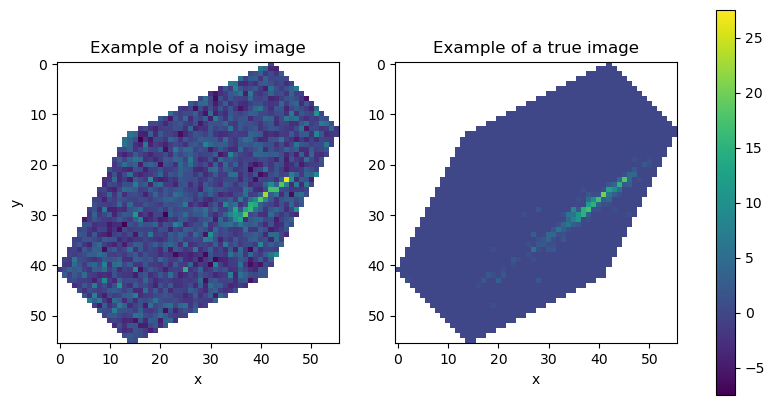

In [21]:
fig_eda, axs = plt.subplots(1, 2, figsize=(10,5))

im_noisy = axs[0].imshow(data_noisy[0], vmin=-7.5, vmax=27.5)
axs[0].set_title(f"Example of a noisy image")
    
im_true = axs[1].imshow(data_true[0], vmin=-7.5, vmax=27.5)
axs[1].set_title(f"Example of a true image")
    
    
axs[0].set_ylabel("y")
axs[0].set_xlabel("x")
axs[1].set_xlabel("x")

fig.colorbar(im_true, ax=axs.ravel().tolist())


plt.show()
fig_eda.savefig("images/Segmentation_EDA.pdf")

**Data Preperation**

In [22]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_binary = np.zeros((64*chunk_tot, 56, 56))
data_true_binary[data_true>threshold] = 1
data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
pix_max = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
pix_min = np.nanmin(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num((data_noisy_arr - pix_min)/(pix_max-pix_min))

data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())
data_noisy_tensor = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
data_true_tensor = (torch.from_numpy(data_true_binary_flat[images_high_mask])).float()

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:]
data_true_test = data_true_tensor[idx_split:]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:]
data_true_test_im = data_true_tensor_im[idx_split:]


In [23]:
# Batch form
batch_size = 1

N, H, W = data_noisy_train.shape
N_new = N//batch_size

data_noisy_train_batch = data_noisy_train[:int(N_new*batch_size)].reshape(N_new, batch_size, 1, H, W)
data_true_train_batch = data_true_train[:int(N_new*batch_size)].reshape(N_new, batch_size, H*W)

**The Autoencoder Model**

In [24]:
# AE with 4 layers

class AE4(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

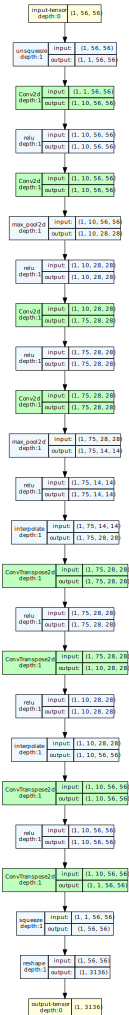

In [25]:
# Visualize the model
model_graph = draw_graph(AE4(), input_size=(1,56,56), expand_nested=True)
model_graph.visual_graph

In [26]:
print("Number of parameters:")
print(sum(p.numel() for p in AE4().parameters() if p.requires_grad))

Number of parameters:
116996


**Define functions for the training and the testing**

In [28]:
learning_rate = 0.001

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

In [29]:
# Functions and definitions for 
n_epochs = 3

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

weight = 2

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train_batch, data_true_train_batch):       
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
            test_loss += loss.item()
            output_data = F.sigmoid(output.data)
            output_binary = output_data.round()
            pred = output.data.max(1, keepdim=True)[1]
            IOU += jaccard_score(output_binary[0], true[0])
    
    test_loss /= len(data_noisy_test)
    IOU /= len(data_noisy_test)
    test_losses.append(test_loss)
    IOU_list.append(IOU)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
    print(f'IOU: {IOU}')

**General Run**

First run is to give a general impression of the performance of the model

In [32]:
%%time

n_epochs = 15

learning_rate = 0.001

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.6956
IOU: 0.0861492682178072
Training set: Avg. loss: 0.1175

Test set: Avg. loss: 0.0833
IOU: 0.4181139200479831
Training set: Avg. loss: 0.0959

Test set: Avg. loss: 0.0811
IOU: 0.469026610074089
Training set: Avg. loss: 0.0902

Test set: Avg. loss: 0.0739
IOU: 0.47945813261611364
Training set: Avg. loss: 0.0870

Test set: Avg. loss: 0.0750
IOU: 0.47770133131839165
Training set: Avg. loss: 0.0852

Test set: Avg. loss: 0.0738
IOU: 0.48493313614780015
Training set: Avg. loss: 0.0854

Test set: Avg. loss: 0.0761
IOU: 0.47420079832499695
Training set: Avg. loss: 0.0833

Test set: Avg. loss: 0.0720
IOU: 0.4842445092449497
Training set: Avg. loss: 0.0826

Test set: Avg. loss: 0.0723
IOU: 0.4880121631748481
Training set: Avg. loss: 0.0823

Test set: Avg. loss: 0.0721
IOU: 0.4835791198531404
Training set: Avg. loss: 0.0818

Test set: Avg. loss: 0.0706
IOU: 0.4884963148042932
Training set: Avg. loss: 0.0809

Test set: Avg. loss: 0.0739
IOU: 0.4794808380257786
Training 

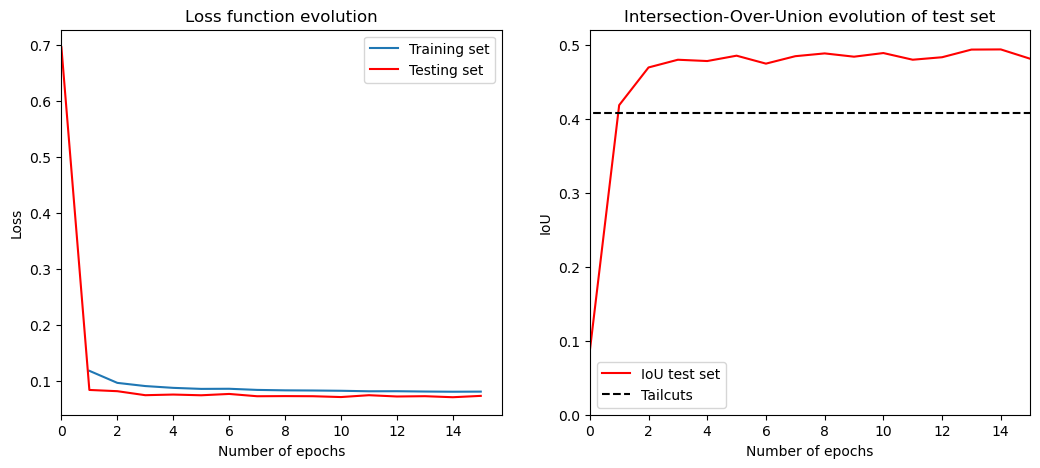

In [34]:
# Plot the fitting results as the loss function and the IoU

fig_gen, axs = plt.subplots(1, 2, figsize=(12.5,5))

axs[0].set_title("Loss function evolution")
axs[0].plot(train_counter, train_losses, label='Training set')
axs[0].plot(test_counter, test_losses, color='red', label='Testing set')
axs[0].set_xlabel("Number of epochs")
axs[0].set_ylabel("Loss")
axs[0].set_xlim(0,)
#axs[0].set_ylim(0,)
axs[0].legend()

axs[1].set_title("Intersection-Over-Union evolution of test set")
axs[1].plot(test_counter, IOU_list, color='red', label='IoU test set')
axs[1].hlines(0.4070115627594698, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
axs[1].set_xlim(0,n_epochs)
axs[1].set_ylim(0,0.52)
axs[1].set_xlabel("Number of epochs")
axs[1].set_ylabel("IoU")
axs[1].legend()

plt.show()
fig_gen.savefig("images/ModelPerformanceGeneral.pdf")

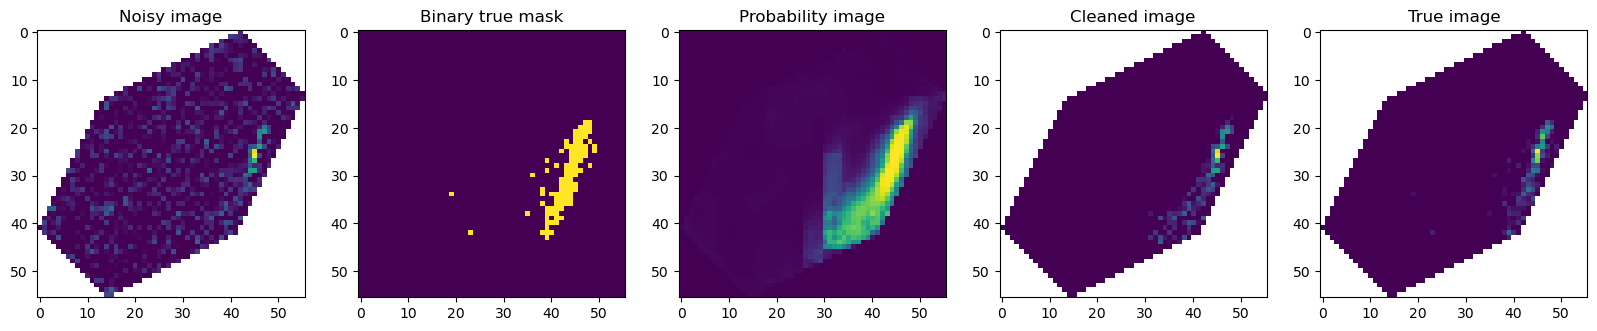

In [35]:
# Use 11 as an example in presentation

im_i = 11

output = network(data_noisy_test[im_i].unsqueeze(0))
output = F.sigmoid(output)
im_clean = output.reshape(1, 56, 56)
im_clean_prob = im_clean.detach()[0].numpy()

im_clean = im_clean_prob.round()
mask_clean = im_clean.astype(bool)
im_clean_good = np.zeros((56,56))

im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
im_clean_good[nan_mask] = np.nan
    
fig, axs = plt.subplots(1,5,figsize=(20,10))

axs[0].imshow(data_noisy_test_im[im_i], vmin=0)
axs[0].set_title("Noisy image")
    
axs[1].imshow((data_true_binary[images_high_mask])[idx_split+im_i])
axs[1].set_title("Binary true mask")
    
fig_clean_prob = axs[2].imshow(im_clean_prob, vmin=0)
axs[2].set_title("Probability image")

axs[3].imshow(im_clean_good, vmin=0)
axs[3].set_title("Cleaned image")

axs[4].imshow(data_true_test_im[im_i], vmin=0)
axs[4].set_title("True image")

plt.show()    



In [36]:
pix_max = np.nanmax(data_noisy_arr, axis=(1,2))
pix_min = np.nanmin(data_noisy_arr, axis=(1,2))

pix_max_test = pix_max[idx_split:]
pix_min_test = pix_min[idx_split:]

In [37]:
# Normalized MSE

MSE_tc = 0
data_true_test_con = data_true[images_high_mask][idx_split:]
i=0
for noisy, true, pixmin, pixmax in zip(data_noisy_test, data_true_test_con, pix_min_test, pix_max_test):
    output = network(data_noisy_test[i].unsqueeze(0))
    output = F.sigmoid(output)
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_test_im[i][mask_clean]
    im_clean_good = im_clean_good/pixmax
    
    im_clean_good[nan_mask] = 0
    true = true/pixmax
    true[nan_mask] = 0
    
    MSE_tc += F.mse_loss(torch.tensor(im_clean_good), torch.tensor(true))

    
    i=i+1
    
MSE_tc = MSE_tc/len(data_noisy_test)
    
print(f'Normalized MSE of tailcuts: {MSE_tc}')

Normalized MSE of tailcuts: 0.0002622524990335802


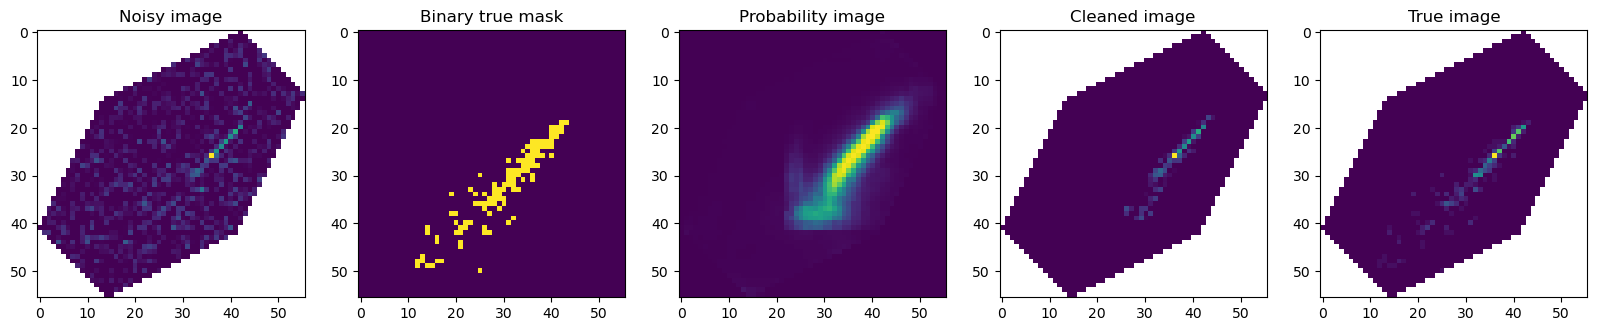

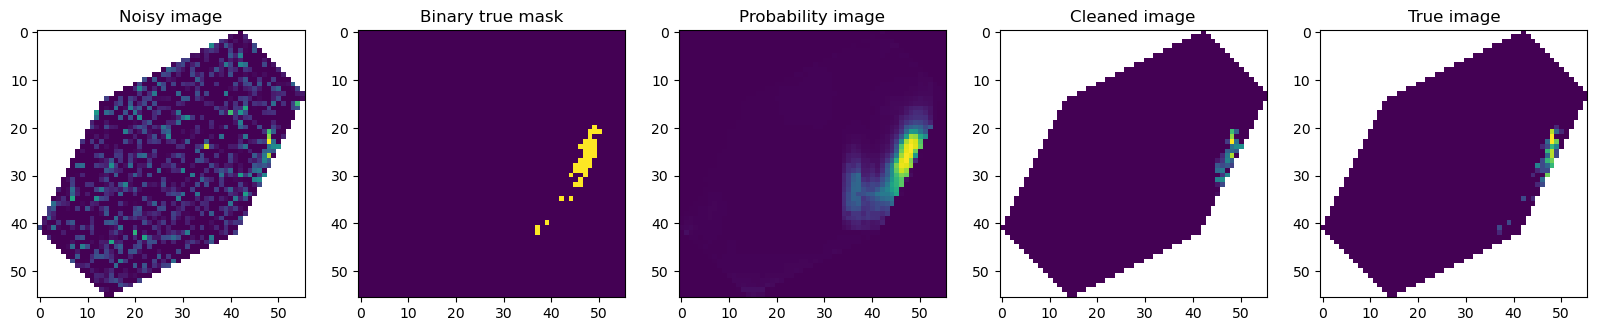

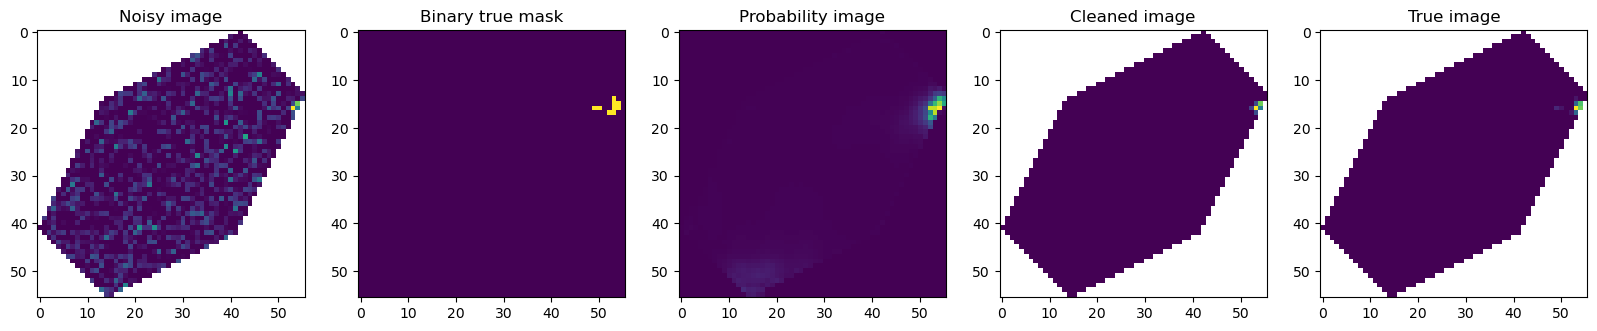

In [57]:
n_start = 18 #9
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))
    output = F.sigmoid(output)
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean_good[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,5,figsize=(20,10))

    axs[0].imshow(data_noisy_test_im[im_i], vmin=0)
    axs[0].set_title("Noisy image")
    
    axs[1].imshow((data_true_binary[images_high_mask])[idx_split+im_i])
    axs[1].set_title("Binary true mask")
    
    fig_clean_prob = axs[2].imshow(im_clean_prob, vmin=0)
    axs[2].set_title("Probability image")

    axs[3].imshow(im_clean_good, vmin=0)
    axs[3].set_title("Cleaned image")

    axs[4].imshow(data_true_test_im[im_i], vmin=0)
    axs[4].set_title("True image")

plt.show()    

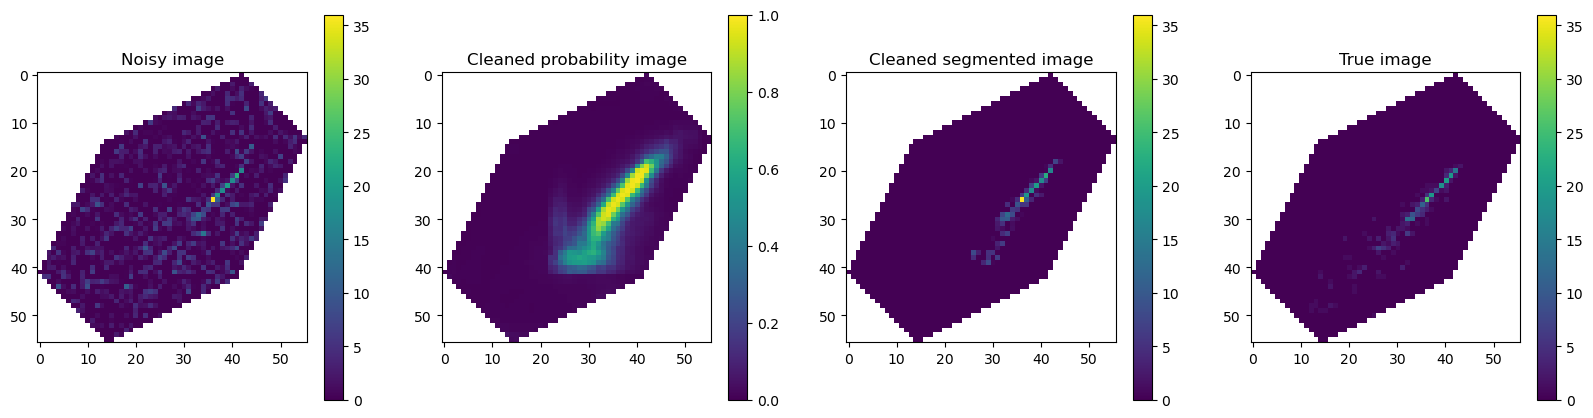

In [72]:
im_i = 18

output = network(data_noisy_test[im_i].unsqueeze(0))
output = F.sigmoid(output)
im_clean = output.reshape(1, 56, 56)
im_clean_prob = im_clean.detach()[0].numpy()

im_clean = im_clean_prob.round()
mask_clean = im_clean.astype(bool)
im_clean_good = np.zeros((56,56))

im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
im_clean_good[nan_mask] = np.nan
    
fig_seg_ex, axs = plt.subplots(1,4,figsize=(20,5))

im_noisy = axs[0].imshow(data_noisy_test_im[im_i], vmin=0, vmax=36)
plt.colorbar(im_noisy, ax=axs[0])
axs[0].set_title("Noisy image")
    
im_clean_prob[nan_mask] = np.nan
fig_clean_prob = axs[1].imshow(im_clean_prob, vmin=0, vmax=1)
plt.colorbar(fig_clean_prob, ax=axs[1])
axs[1].set_title("Cleaned probability image")

im_clean = axs[2].imshow(im_clean_good, vmin=0, vmax=36)
plt.colorbar(im_clean, ax=axs[2])
axs[2].set_title("Cleaned segmented image")

im_true = axs[3].imshow(data_true_test_im[im_i], vmin=0, vmax=36)
plt.colorbar(im_true, ax=axs[3])
axs[3].set_title("True image")

plt.show()  
fig_seg_ex.savefig("images/SegCleanExample.pdf")

In [39]:
IOU_dis = []
for noisy, true in zip(data_noisy_test, data_true_test):
    
    noisy = noisy.unsqueeze(0)
    true = true.unsqueeze(0)

    output = network(noisy)   
    output_data = F.sigmoid(output.data)
    output_binary = output_data.round()
    iou = IOU_calc(output_binary, true)
    IOU_dis.append(iou)
    
IOU_dis_arr = np.array(IOU_dis)

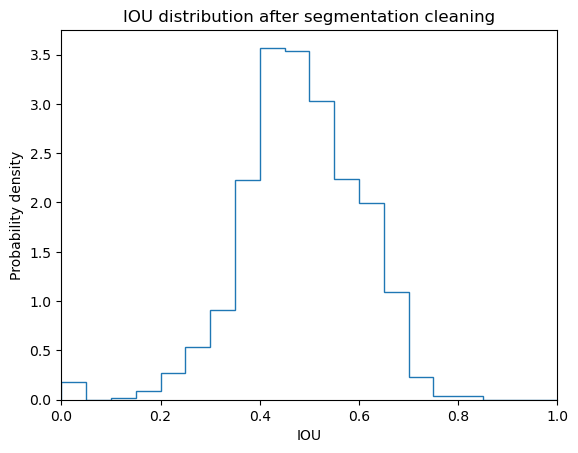

In [41]:
fig_seg_dis = plt.figure()
plt.hist(IOU_dis_arr, range=(0,1), bins=20, density=True, histtype='step')
plt.xlim(0,1)
plt.xlabel("IOU")
plt.ylabel("Probability density")
plt.title("IOU distribution after segmentation cleaning")
plt.show()
fig_seg_dis.savefig("images/SegmentationDistribution.pdf")

np.save("data_output/IOU_seg_dis.npy", IOU_dis_arr)

**Run with uncertainties**

The goal of this section is to show how the spread is of different runs of the same model.

In [42]:
%%time

n_runs = 5
IOU_all = []
n_epochs = 15

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)

for i in range(0, n_runs):
    print()
    print(f"Run {i+1}")
    network = AE4()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    IOU_list = []

    test()
    for epoch in range(1, n_epochs + 1):
        train(epoch)
        test()
    
    IOU_all.append(IOU_list)
    
IOU_all_arr = np.array(IOU_all)


Run 1

Test set: Avg. loss: 0.7357
IOU: 0.022421100063239472
Training set: Avg. loss: 0.1202

Test set: Avg. loss: 0.0814
IOU: 0.4272102564188483
Training set: Avg. loss: 0.0965

Test set: Avg. loss: 0.0770
IOU: 0.45805603986071375
Training set: Avg. loss: 0.0907

Test set: Avg. loss: 0.0754
IOU: 0.4675901472100738
Training set: Avg. loss: 0.0876

Test set: Avg. loss: 0.0751
IOU: 0.4764442570800138
Training set: Avg. loss: 0.0855

Test set: Avg. loss: 0.0775
IOU: 0.46726772144490136
Training set: Avg. loss: 0.0846

Test set: Avg. loss: 0.0716
IOU: 0.4880829140713255
Training set: Avg. loss: 0.0839

Test set: Avg. loss: 0.0728
IOU: 0.4770213545828757
Training set: Avg. loss: 0.0823

Test set: Avg. loss: 0.0731
IOU: 0.4891086857805029
Training set: Avg. loss: 0.0829

Test set: Avg. loss: 0.0723
IOU: 0.4816679957382285
Training set: Avg. loss: 0.0820

Test set: Avg. loss: 0.0714
IOU: 0.49257849230798356
Training set: Avg. loss: 0.0817

Test set: Avg. loss: 0.0719
IOU: 0.4852108313130775


In [43]:
# Some operations to find the mean and the uncertainty bands

IOU_mean = np.mean(IOU_all_arr, axis=0)
IOU_std = np.std(IOU_all_arr, axis=0)

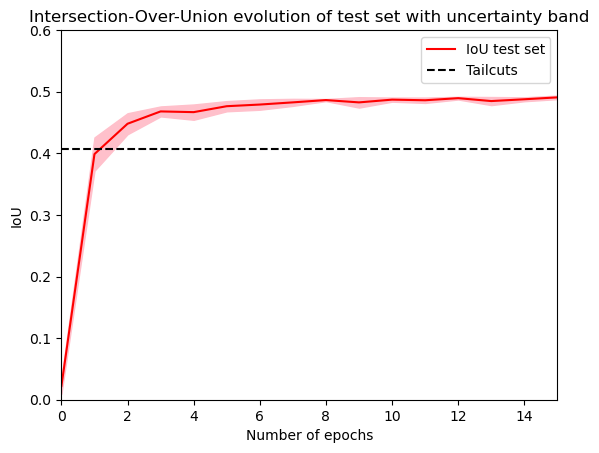

In [44]:
plt.figure()
plt.title("Intersection-Over-Union evolution of test set with uncertainty band")
plt.plot(test_counter, IOU_mean, color='red', label='IoU test set')
plt.fill_between(test_counter, IOU_mean-IOU_std, IOU_mean+IOU_std, color='pink')
plt.hlines(0.4070115627594698, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
plt.xlim(0,n_epochs)
plt.ylim(0,0.6)
plt.xlabel("Number of epochs")
plt.ylabel("IoU")
plt.legend()
plt.show()

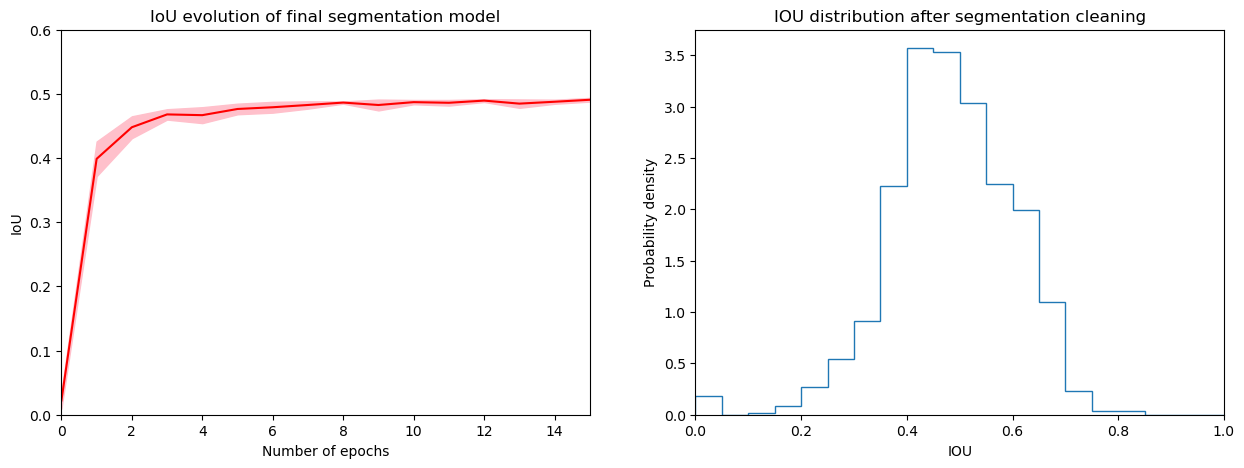

In [50]:
# Plot for report

fig_perf, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].set_title("IoU evolution of final segmentation model")
axs[0].plot(test_counter, IOU_mean, color='red')
axs[0].fill_between(test_counter, IOU_mean-IOU_std, IOU_mean+IOU_std, color='pink')
axs[0].set_xlim(0,n_epochs)
axs[0].set_ylim(0,0.6)
axs[0].set_xlabel("Number of epochs")
axs[0].set_ylabel("IoU")

axs[1].hist(IOU_dis_arr, range=(0,1), bins=20, density=True, histtype='step')
axs[1].set_xlim(0,1)
axs[1].set_xlabel("IOU")
axs[1].set_ylabel("Probability density")
axs[1].set_title("IOU distribution after segmentation cleaning")

plt.show()
fig_perf.savefig("images/FinalPerformance.pdf")

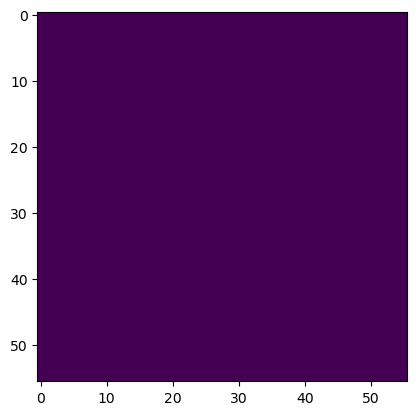

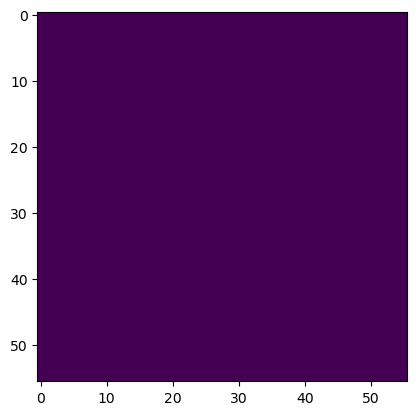

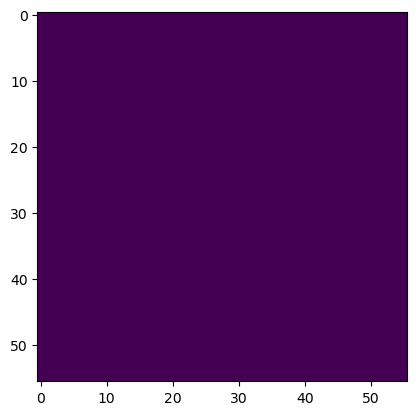

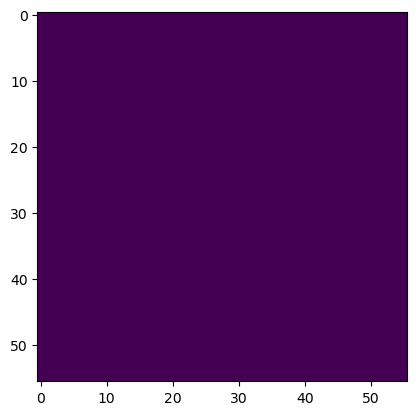

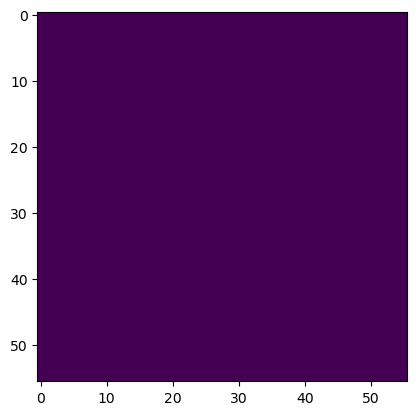

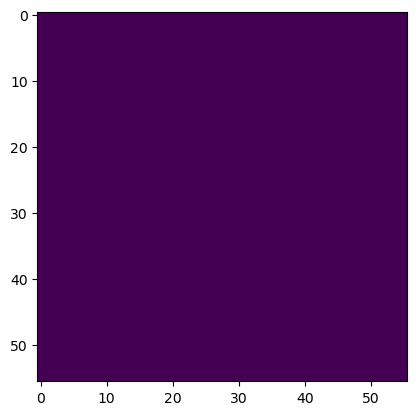

In [51]:
for noisy, true in zip(data_noisy_test, data_true_test):
    
    noisy = noisy.unsqueeze(0)
    true = true.unsqueeze(0)

    output = network(noisy)   
    output_data = F.sigmoid(output.data)
    output_binary = output_data.round()
    iou = IOU_calc(output_binary, true)
    if iou < 0.05:
        plt.figure()
        plt.imshow(output_binary.reshape(56,56))
        plt.show()
    

**Long run**

Now a very long to see the behaviour of the fitting in the long term

In [73]:
%%time

n_epochs = 100

learning_rate = 0.0005

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.5561
IOU: 0.01590296233801387
Training set: Avg. loss: 0.1183

Test set: Avg. loss: 0.0845
IOU: 0.4277739051076395
Training set: Avg. loss: 0.0961

Test set: Avg. loss: 0.0849
IOU: 0.46813943738559305
Training set: Avg. loss: 0.0895

Test set: Avg. loss: 0.0733
IOU: 0.48314404093136615
Training set: Avg. loss: 0.0863

Test set: Avg. loss: 0.0729
IOU: 0.4832692793061407
Training set: Avg. loss: 0.0838

Test set: Avg. loss: 0.0714
IOU: 0.4882718673193374
Training set: Avg. loss: 0.0821

Test set: Avg. loss: 0.0707
IOU: 0.4916479071454289
Training set: Avg. loss: 0.0808

Test set: Avg. loss: 0.0732
IOU: 0.479452588071043
Training set: Avg. loss: 0.0800

Test set: Avg. loss: 0.0717
IOU: 0.48586117987616506
Training set: Avg. loss: 0.0794

Test set: Avg. loss: 0.0699
IOU: 0.49644715179568444
Training set: Avg. loss: 0.0782

Test set: Avg. loss: 0.0703
IOU: 0.4960203839039643
Training set: Avg. loss: 0.0778

Test set: Avg. loss: 0.0701
IOU: 0.49622594166256584
Trainin

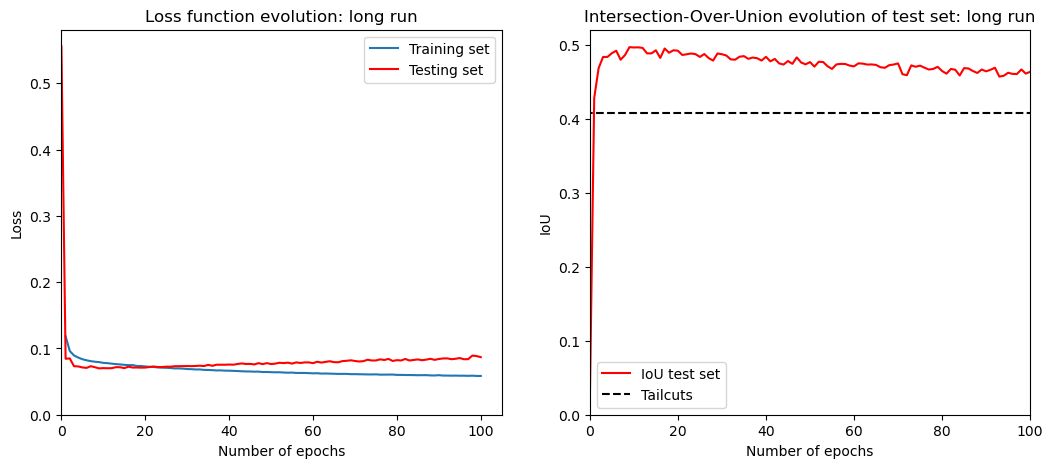

In [74]:
# Plot the fitting results as the loss function and the IoU

fig, axs = plt.subplots(1, 2, figsize=(12.5,5))

axs[0].set_title("Loss function evolution: long run")
axs[0].plot(train_counter, train_losses, label='Training set')
axs[0].plot(test_counter, test_losses, color='red', label='Testing set')
axs[0].set_xlabel("Number of epochs")
axs[0].set_ylabel("Loss")
axs[0].set_xlim(0,)
axs[0].set_ylim(0,)
axs[0].legend()

axs[1].set_title("Intersection-Over-Union evolution of test set: long run")
axs[1].plot(test_counter, IOU_list, color='red', label='IoU test set')
axs[1].hlines(0.4070115627594698, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
axs[1].set_xlim(0,n_epochs)
axs[1].set_ylim(0,0.52)
axs[1].set_xlabel("Number of epochs")
axs[1].set_ylabel("IoU")
axs[1].legend()

plt.show()